In [1]:
import itertools
import json
import math
import random
import time
import matplotlib.pyplot as plt
import numpy as np

**Preliminaries taken from model.py**

In [2]:
fan_in = 3


def precompute_xi(N, fan=fan_in):
    xi = []
    for k in range(N):
        test = []
        for f in range(fan + 1):
            for j in range(min(k, f) + 1):
                mismatch = math.comb(k, j) * math.comb(N - 1 - k, f - j)
                lt = [(k - j) + (f - j)] * mismatch
                test.extend(lt)
        test.sort()
        xi.append(test)

    return xi


def generate_parent_configs(N, v_k):
    nodes = [i for i in range(N) if i != v_k]

    parent_sets = []
    for r in range(0, fan_in + 1): 
        parent_sets.extend(itertools.combinations(nodes, r))

    parent_sets = [set(tup) for tup in parent_sets]
    return parent_sets


def RAF_pathway():
    return np.array(
        [
            [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1],
            [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
            [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
            [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        ]
    )


def topol_order(incidence): 
    n = len(incidence[0])
    Order = np.zeros(n, dtype=int)
    fan_in = np.zeros(n, dtype=int)
    no_fan_in = []

    for p in range(n):
        fan_in[p] = np.sum(incidence[:, p])

    no_fan_in = np.where(fan_in == 0)[0].tolist()

    m = 0
    while np.sum(Order == 0) > 0: 
        next_node = no_fan_in[0]
        connected_nodes = np.where(incidence[next_node, :] == 1)[0]
        fan_in[connected_nodes] -= 1


        newly_zero_fan_in = np.where(fan_in == 0)[0]
        no_fan_in += [
            node
            for node in connected_nodes
            if node in newly_zero_fan_in and node not in no_fan_in
        ]

        Order[m] = next_node + 1 
        no_fan_in.pop(0)
        m += 1

    return Order


def child(edges, n):
    p = np.ceil(edges / n).astype(int)
    return p


def parent(edges, n):
    ch = edges + n - child(edges, n) * n
    return ch


def order_edges(incidence):
    top_ordering = topol_order(incidence)
    n = len(top_ordering)

    edges = (
        np.where(incidence.flatten(order="F") != 0)[0] + 1
    ) 
    children = child(edges, n)
    parents = parent(edges, n)
    m = len(edges)

    ordered_edges = np.zeros(m, dtype=int)
    incidence_n = incidence.copy() 

    tog = np.vstack(
        (edges, parents, children, ordered_edges)
    ).T 
    k = 1

    while np.any(tog[:, 3] == 0):

        incidence_submatrix = incidence_n[:, top_ordering - 1]
        col_sums = np.sum(incidence_submatrix, axis=0)
        nodes_with_parents = np.where(col_sums > 0)[0]
        if len(nodes_with_parents) == 0:
            print("No nodes with parents. Exiting.")
            break
        node1 = top_ordering[nodes_with_parents[0]]

        condition = tog[:, 2] == node1
        par1 = tog[condition, 1]
        g = par1[par1 > 0] 

        if len(g) == 0:
            print(f"No valid parents for node {node1}. Skipping.")
            break

        f1 = np.array([np.where(top_ordering == g_i)[0][0] for g_i in g])
        par2 = g[np.argmax(f1)]

        condition = (tog[:, 1] == par2) & (tog[:, 2] == node1)
        tog[condition, 3] = k
        k += 1

        matching_rows = np.where(condition)[0]

        for row in matching_rows:
            edge_row = parents[row] - 1  
            edge_col = children[row] - 1  

            incidence_n[edge_row, edge_col] = 0

        tog[condition, 1] = 0

    result = np.vstack((edges, parents, children, tog[:, 3])).T
    return result


def cpdag(incidence):
    z = order_edges(incidence)
    new_mat = np.column_stack(
        (z, np.zeros(z.shape[0]))
    ) 
    n_mat = new_mat[np.argsort(new_mat[:, 3])]  
    vec = np.zeros(z.shape[0])

    while np.any(vec == 0):  
        if len(vec) > 1:  
            first = np.where(n_mat[:, 4] == 0)[0][0]  
            parent1 = int(n_mat[first, 1]) - 1  
            child1 = int(n_mat[first, 2]) - 1  
            comp1 = n_mat[
                np.where((n_mat[:, 2] == parent1 + 1) & (n_mat[:, 4] == 1)), 1
            ]  
        else:
            first = np.where(n_mat[:, 4] == 0)[0]  
            parent1 = int(n_mat[first, 1]) - 1  
            child1 = int(n_mat[first, 2]) - 1  
            comp1 = np.array([])  

        for j in np.atleast_1d(comp1).flat:  
            j = int(j) - 1  
            if incidence[j, child1] == 0:  
                n_mat[first, 4] = 1  
                n_mat[np.where(n_mat[:, 2] == child1 + 1), 4] = (
                    1  
                )
                vec[first] = 1
                vec[np.where(n_mat[:, 2] == child1 + 1)] = 1
                break
            elif incidence[j, child1] != 0:  
                idx = np.where(
                    (n_mat[:, 1] == j + 1) & (n_mat[:, 2] == child1 + 1)
                )  
                n_mat[idx, 4] = 1  
                vec[idx] = 1

        if len(vec) > 1 and n_mat[first, 4] == 0:  
            moep = (
                n_mat[
                    np.where(
                        (n_mat[:, 2] == child1 + 1) & (n_mat[:, 1] != parent1 + 1)
                    ),
                    1,
                ]
                .astype(int)
                .flatten()
            )

            if len(moep) > 0:
                for (
                    o
                ) in (
                    moep
                ):  
                    o = int(o) - 1  
                    if incidence[o, parent1] == 0:  
                        vec[first] = 1
                        vec[
                            np.where((n_mat[:, 2] == child1 + 1) & (n_mat[:, 4] == 0))
                        ] = 1
                        n_mat[first, 4] = 1  
                        n_mat[
                            np.where((n_mat[:, 2] == child1 + 1) & (n_mat[:, 4] == 0)),
                            4,
                        ] = 1  
                        break
                    elif np.all(
                        incidence[moep.astype(int) - 1, parent1] != 0
                    ):  
                        vec[first] = -1
                        vec[
                            np.where((n_mat[:, 2] == child1 + 1) & (n_mat[:, 4] == 0))
                        ] = -1
                        n_mat[first, 4] = -1  
                        n_mat[
                            np.where((n_mat[:, 2] == child1 + 1) & (n_mat[:, 4] == 0)),
                            4,
                        ] = -1  
            else:
                vec[first] = -1
                vec[np.where((n_mat[:, 2] == child1 + 1) & (n_mat[:, 4] == 0))] = -1
                n_mat[first, 4] = -1  
                n_mat[np.where((n_mat[:, 2] == child1 + 1) & (n_mat[:, 4] == 0)), 4] = (
                    -1
                )  

        if len(vec) == 1:
            n_mat[0, 4] = -1  
            vec[0] = -1

    return n_mat


def create_pseudoincidence_matrix(edge_matrix, N):
    pseudoincidence_matrix = np.zeros((N, N), dtype=int)

    for edge in edge_matrix:
        source = int(edge[1]) - 1  
        target = int(edge[2]) - 1 
        direction = int(edge[4])

        if direction == 1:
            pseudoincidence_matrix[source, target] = 1
        elif direction == -1:
            pseudoincidence_matrix[source, target] = -1
            pseudoincidence_matrix[target, source] = -1

    return pseudoincidence_matrix

**my_partition - partition function with EPGA; orignal_parition - partition function with PGA**

In [3]:
def my_partition(M_hyp, beta_k, p):

    start_time = time.perf_counter()

    N = M_hyp.shape[0]
    Z = 1
    for n in range(N):
        k = np.count_nonzero(M_hyp[:, n] == 1)
        xi_k = p[k]
        trial_test = sum(np.exp(-beta_k * el) for el in xi_k)
        Z = Z * trial_test
    end_time = time.perf_counter()
    return end_time - start_time


def original_partition(M_hyp, beta_k, p):

    start_time = time.perf_counter()

    N = M_hyp.shape[0]
    all_nodes = set(range(M_hyp.shape[0]))
    Z = 1
    for n in range(N):
        parent_configurations = p[n]
        L = []
        for parent_set in parent_configurations:
            local_hamming = 0
            for i in all_nodes:
                if i in parent_set:
                    local_hamming += 1 - M_hyp[i][n]
                else:
                    local_hamming += M_hyp[i][n]
            L.append(local_hamming)
        trial = sum(np.exp(-beta_k * el) for el in L)
        Z = Z * trial
    end_time = time.perf_counter()
    return end_time - start_time

In [4]:
def generate_dag(num_nodes, max_parents=3):
    adj_matrix = np.zeros((num_nodes, num_nodes), dtype=int)

    for node in range(1, num_nodes):  
        num_parents = random.choice([0, 1, 2, 3])

        num_parents = min(
            num_parents, node
        ) 

        parents = random.sample(range(node), num_parents)

        for parent in parents:
            adj_matrix[parent, node] = 1  

    return adj_matrix


def generate_dags(num_dags, min_nodes=5, max_nodes=100, max_parents=3):
    dags = []
    for size in np.linspace(min_nodes, max_nodes, num_dags, dtype=int):
        dag = generate_dag(size, max_parents)
        dags.append(dag)
    return dags

**Running the cell below gives result similar to Figure 4.1 from the thesis.**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


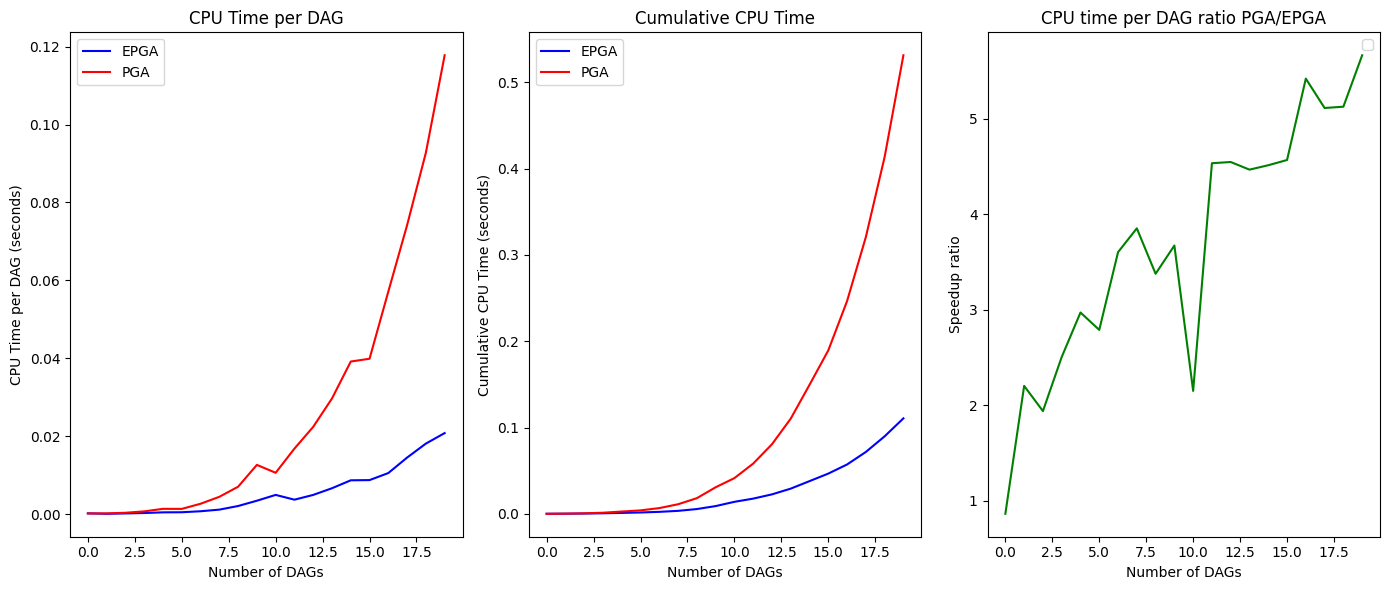

In [5]:
DAGs = generate_dags(20, min_nodes=5, max_nodes=20, max_parents=3)  # max_nodes = 100 gives a result similar to Figure 4.1 (but the computation is expensive)

times_algo1 = []
times_algo2 = []
cumulative_times_algo1 = []
cumulative_times_algo2 = []
cumulative_time_algo1 = 0
cumulative_time_algo2 = 0

for dag in DAGs:
    N = dag.shape[0]
    xi_sets = precompute_xi(N)
    time_taken_algo1 = my_partition(dag, beta_k=1, p=xi_sets)
    times_algo1.append(time_taken_algo1)
    cumulative_time_algo1 += time_taken_algo1
    cumulative_times_algo1.append(cumulative_time_algo1)

    pi_sets = []
    for n in range(N):
        pi_sets.append(generate_parent_configs(N, n))
    time_taken_algo2 = original_partition(dag, beta_k=1, p=pi_sets)
    times_algo2.append(time_taken_algo2)
    cumulative_time_algo2 += time_taken_algo2
    cumulative_times_algo2.append(cumulative_time_algo2)

speedup = [t2 / t1 if t1 != 0 else 0 for t1, t2 in zip(times_algo1, times_algo2)]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 6))

ax1.plot(range(len(DAGs)), times_algo1, label="EPGA", color='blue')
ax1.plot(range(len(DAGs)), times_algo2, label="PGA", color='red')
ax1.set_xlabel("Number of DAGs")
ax1.set_ylabel("CPU Time per DAG (seconds)")
ax1.set_title("CPU Time per DAG")
ax1.legend()

ax2.plot(range(len(DAGs)), cumulative_times_algo1, label="EPGA", color='blue')
ax2.plot(range(len(DAGs)), cumulative_times_algo2, label="PGA", color='red')
ax2.set_xlabel("Number of DAGs")
ax2.set_ylabel("Cumulative CPU Time (seconds)")
ax2.set_title("Cumulative CPU Time")
ax2.legend()

ax3.plot(range(len(DAGs)), speedup, color='green')
ax3.set_xlabel("Number of DAGs")
ax3.set_ylabel("Speedup ratio")
ax3.set_title("CPU time per DAG ratio PGA/EPGA")
ax3.legend()

plt.tight_layout()
plt.show()

In [6]:
def my_partition(M_hyp, beta_k, p):

    start_time = time.perf_counter()

    N = M_hyp.shape[0]
    Z = 1
    for n in range(N):
        k = np.count_nonzero(M_hyp[:, n] == 1)
        xi_k = p[k]
        trial_test = sum(np.exp(-beta_k * el) for el in xi_k)
        Z = Z * trial_test
    end_time = time.perf_counter()
    # return end_time - start_time
    return np.log(Z)

def skeleton_partition(M_hyp, beta_k, p):
    # start_time = time.perf_counter()
    saki = M_hyp + np.transpose(M_hyp)
    Z = 1
    N = M_hyp.shape[0]
    for n in range(N):
        k = np.count_nonzero(saki[:, n] == 1)
        # print(" k = ", k)
        if k != 0:
            cargo = []
            for j in range(min(4, k + 1)):
                cargo.append(p[j])
            cargo_sum = np.sum(cargo, axis=0)
            xi_k = [x * (1 / (min(4, k + 1))) for x in cargo_sum]
            trial_test = sum((np.exp(-beta_k * el) for el in xi_k))
        else:
            xi_k = p[k]
            trial_test = sum((np.exp(-beta_k * el) for el in xi_k))
        Z = Z * trial_test
    return np.log(Z)
    # return end_time - start_time


def cpdag_partition(M_hyp, beta_k, p):
    Z = 1
    N = M_hyp.shape[0]
    M_hyp = create_pseudoincidence_matrix(cpdag(M_hyp), M_hyp.shape[0])
    for n in range(N):
        k = np.count_nonzero(M_hyp[:, n] == 1)
        l = np.count_nonzero(M_hyp[:, n] == -1)
        if l == 0:
            xi_k = p[k]
            trial_test = sum(np.exp(-beta_k * el) for el in xi_k)
        else:
            cargo = []
            for j in range(k, min(4, l + k + 1)):
                cargo.append(p[j])
            cargo_sum = np.sum(cargo, axis=0)
            xi_k = [x * (1 / (min(4 - k, l + 1))) for x in cargo_sum]
            trial_test = sum((np.exp(-beta_k * el) for el in xi_k))

        Z = Z * trial_test
    return np.log(Z)

**Running the cell below (warning, computationally expensive) gives result similar to Figure 4.4.**

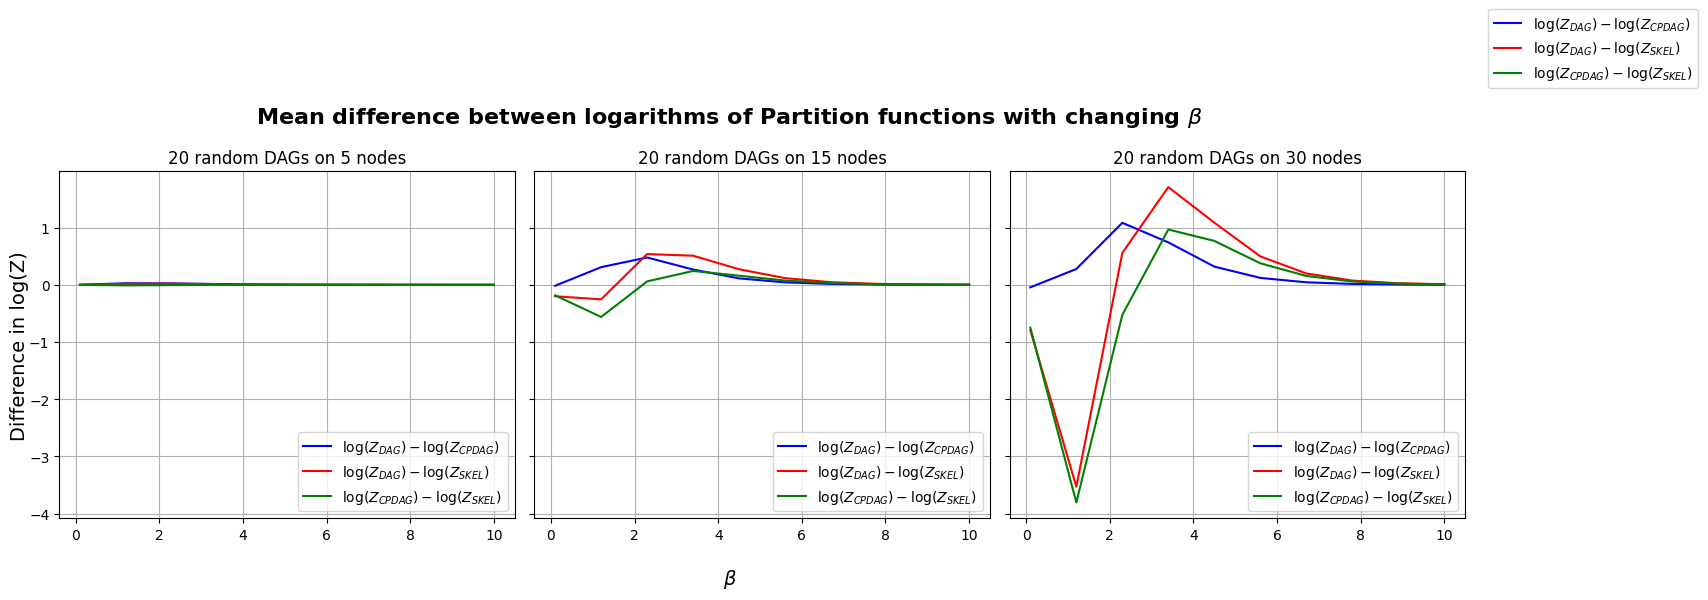

In [7]:
num_samples = 20
betas = np.linspace(0.1, 10, 10)  # original is np.linspace(0.1, 10, 400), but it is computationally expensive
Number_of_nodes = [5, 15, 30]

fig, axes = plt.subplots(
    1, 3, figsize=(15, 5), sharex=True, sharey=True
)  

for i, nodes in enumerate(Number_of_nodes):
    all_error_12 = []
    all_error_13 = []
    all_error_23 = []
    DAGs = generate_dags(
        20, min_nodes=nodes, max_nodes=nodes, max_parents=3
    )  
    for _ in range(num_samples):
        RAF = random.choice(DAGs)
        N = RAF.shape[0]
        xi_sets = precompute_xi(N)

        outputs1 = [my_partition(RAF, beta, p=xi_sets) for beta in betas]
        outputs2 = [cpdag_partition(RAF, beta, p=xi_sets) for beta in betas]
        outputs3 = [skeleton_partition(RAF, beta, p=xi_sets) for beta in betas]

        all_error_12.append(np.array(outputs1) - np.array(outputs2))
        all_error_13.append(np.array(outputs1) - np.array(outputs3))
        all_error_23.append(np.array(outputs2) - np.array(outputs3))

    all_error_12 = np.array(all_error_12)
    all_error_13 = np.array(all_error_13)
    all_error_23 = np.array(all_error_23)

    mean_error_12 = np.mean(all_error_12, axis=0)
    mean_error_13 = np.mean(all_error_13, axis=0)
    mean_error_23 = np.mean(all_error_23, axis=0)

    ax = axes[i]
    ax.plot(
        betas, mean_error_12, label=r"$\log(Z_{DAG}) - \log(Z_{CPDAG})$", color="blue"
    )
    ax.plot(
        betas, mean_error_13, label=r"$\log(Z_{DAG}) - \log(Z_{SKEL})$", color="red"
    )
    ax.plot(
        betas, mean_error_23, label=r"$\log(Z_{CPDAG}) - \log(Z_{SKEL})$", color="green"
    )
    ax.legend(loc="lower right")

    ax.set_title(f"20 random DAGs on {nodes} nodes", fontsize=12)
    ax.grid(True)

fig.supxlabel(r"$\beta$", fontsize=14)
fig.supylabel("Difference in log(Z)", fontsize=14)

fig.suptitle(
    r"Mean difference between logarithms of Partition functions with changing $\beta$",
    fontsize=16,
    fontweight="bold",
)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower right", bbox_to_anchor=(1.15, 1))

plt.tight_layout()
plt.show()